### Import các thư viện

In [1]:
# Regular EDA (Exploratory data analysis) and ploting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline 
# Models from Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

### Tải dataset

In [ ]:
df = pd.read_csv('data/Cardiovascular_Disease_Dataset.csv')
df.head(10)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1
5,148462,24,1,1,173,0,0,0,161,0,4.7,3,2,1
6,168686,79,1,2,130,240,0,2,157,0,2.5,2,1,1
7,170498,52,1,0,127,345,0,0,192,1,4.9,1,0,0
8,188225,62,1,0,121,357,0,1,138,0,2.8,0,0,0
9,192523,61,0,0,190,181,0,1,150,0,2.9,2,0,1


### Kiểm tra shape dữ liệu

In [8]:
nRow, nCol = df.shape
print("Shape of dataset {}".format(df.shape))
print(f"Rows: {nRow} \nColumns: {nCol}")

Shape of dataset (1000, 14)
Rows: 1000 
Columns: 14


In [10]:
df.columns

Index(['patientid', 'age', 'gender', 'chestpain', 'restingBP',
       'serumcholestrol', 'fastingbloodsugar', 'restingrelectro',
       'maxheartrate', 'exerciseangia', 'oldpeak', 'slope', 'noofmajorvessels',
       'target'],
      dtype='object')

### Chia dữ liệu thành các tập train và tập test

In [12]:
# Split data into X and y
X = df.drop(["patientid","target"], axis=1)

y = df["target"]

In [193]:
# Split data into train and test sets
np.random.seed(42)

# Split into train and test set
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

Chúng ta sẽ thử với các mô hình sau:
> 1. Logistic Regression
> 2. K-Nearest Neighbour Classifier
> 3. Random Forest Classifier

### Scaling Data

In [ ]:


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [201]:
mean_std_values = {'mean': scaler.mean_, 'std': scaler.scale_}
with open('model/mean_std_values.pkl', 'wb') as f:
    pickle.dump(mean_std_values, f)

In [203]:
# Puts model into a dictionary

models = {"Logistic Regression": LogisticRegression(),
          "KNN":KNeighborsClassifier(), 
          "Random Forest":RandomForestClassifier()}

# Create a function to fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to data
        model.fit(X_train,y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test,y_test)
    return model_scores

In [207]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)
model_scores

{'Logistic Regression': 0.965, 'KNN': 0.935, 'Random Forest': 0.99}

### So Sánh Giữa Các Mô Hình

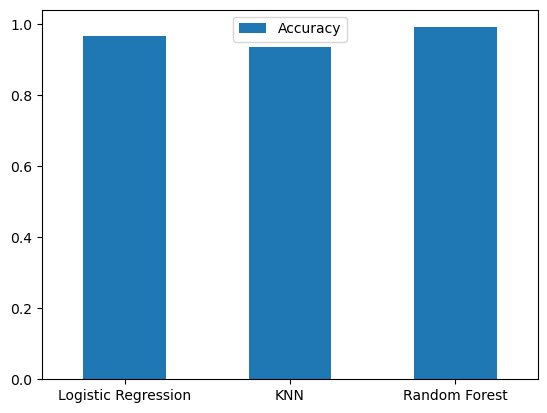

In [23]:
model_compare = pd.DataFrame(model_scores,
                             index=["Accuracy"])
model_compare.T.plot.bar()
plt.xticks(rotation=0);

### Hyperparameter Tuning 

### 1. KNN

In [ ]:
# Tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1,21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop thorugh different n_neighbors

for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train,y_train))
    
    # Update the testing scores list
    test_scores.append(knn.score(X_test,y_test))

In [27]:
knn.set_params(n_neighbors = np.argmax(test_scores)+1 )
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

Maximum KNN score on the test data: 96.00%


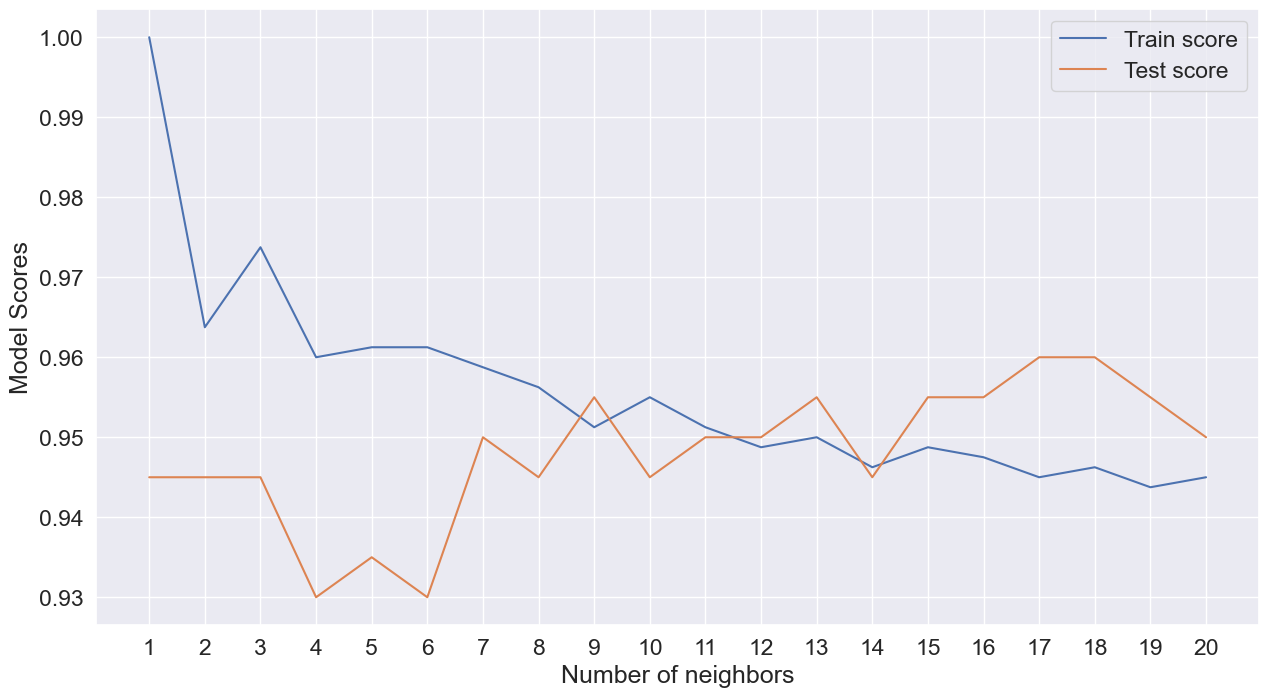

In [213]:
plt.figure(figsize=(15, 8))
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label = "Test score")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model Scores")
plt.legend()
print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%");

## Hyperparameter tuning with Randomized SearchCV
2. LogisticRegression()
3. RandomForestCLassfier()

Using RandomizedSearchCV

In [74]:
# Create a hyperparameter grid for Logistic Regression

log_reg_grid = {"C":np.logspace(-4,4,30),
                "solver":["liblinear"]}

# Create hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators" : np.arange(10,100,50),
          "max_depth":[None,3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf":np.arange(1,20,2)}

Sau khi setup hyperparameter grid cho cả 2 mô hình, ta tuning với RandomizedSearchCV<br/>
Tune LogisticRegression

In [35]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for logisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# Fit Random hyperparameter search model for logisticRegression
rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 2807.2162039411755}

In [39]:
rs_log_reg.score(X_test,y_test)

0.7951219512195122

Tuning RandomForestClassifier

In [39]:
# Setup Random seed
np.random.seed(42)

# Setup random hyperparameters search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=100,
                           verbose=True)

# Fit the random Hyperprameter search mode for randomforestclassifier()
rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 60])},
                   verbose=True)

In [41]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 60,
 'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_depth': None}

In [42]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test,y_test)

0.97

## Evaluating our tuned machine learning classifier.

* Confusion Matrix
* Classification report
* Precision
* Recall
* F1-Score

In [229]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test,y_preds):
    """ 
    Plot a confusion matrix using seaborn's heatmap(
    """
    fig,ax=plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                    annot=True,
                    cbar=False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        83
           1       0.97      0.96      0.97       117

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



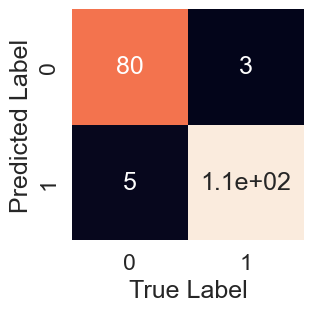

In [227]:
y_preds = knn.predict(X_test)
plot_conf_mat(y_test,y_preds)
print("KNN Classification Report:")
print(classification_report(y_test,y_preds))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        83
           1       0.97      0.97      0.97       117

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



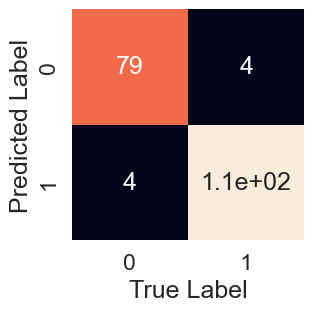

In [92]:
# Logistic Regression
# Evaluate the model with best parameters
rs_log_reg_model = rs_log_reg.best_estimator_
y_preds_rs_log_reg_model = rs_log_reg_model.predict(X_test)
plot_conf_mat(y_test, y_preds_rs_log_reg_model) 
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_preds_rs_log_reg_model))

Random Forest Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        83
           1       0.97      0.97      0.97       117

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



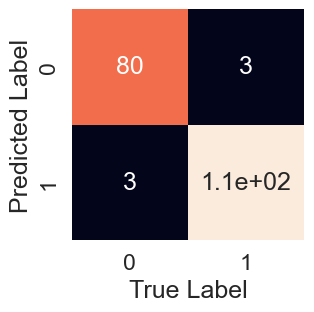

In [106]:
# Random Forest
# Evaluate the model with best parameters
rs_rf_model = rs_rf.best_estimator_
y_preds_rs_rf_model = rs_rf_model.predict(X_test)
plot_conf_mat(y_test, y_preds_rs_rf_model)
print("Random Forest Classification Report for Random Forest:")
print(classification_report(y_test, y_preds_rs_rf_model))

### Calculate evaluation metrics using CrossValidation

In [247]:
knn.score(X_test,y_test)

0.96

In [249]:
# Cross-validated accuaracy
cv_acc_knn = cross_val_score(knn,X,y,cv=5,scoring="accuracy")
cv_acc_knn = np.mean(cv_acc_knn)

In [251]:
# Cross-validated precision
cv_precision_knn = cross_val_score(knn,X,y,cv=5,scoring="precision")
cv_precision_knn = np.mean(cv_precision_knn)

In [253]:
# Cross-validated recall
cv_recall_knn = cross_val_score(knn,X,y,cv=5,scoring="recall")
cv_recall_knn = np.mean(cv_recall_knn)

In [255]:
# Cross-validated f1-score
cv_f1_knn = cross_val_score(knn,X,y,cv=5,scoring="f1")
cv_f1_knn = np.mean(cv_f1_knn)

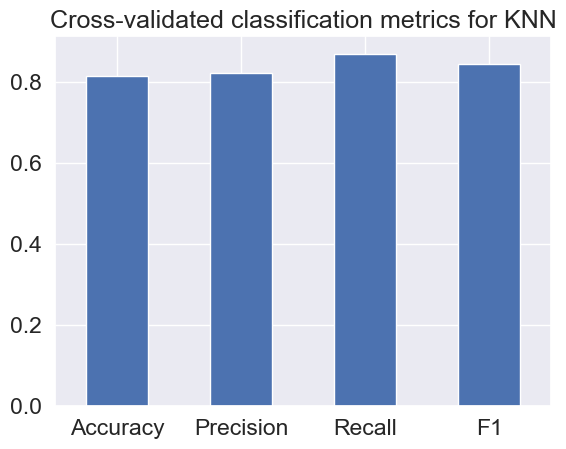

In [259]:
# Visuzalize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy":cv_acc_knn,
                          "Precision":cv_precision_knn,
                          "Recall":cv_recall_knn,
                          "F1":cv_f1_knn},
                         index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics for KNN",
                     legend=False)
plt.xticks(rotation=0);

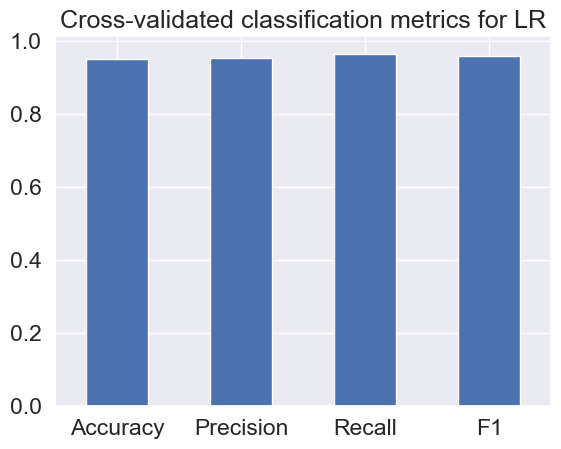

In [267]:
# Cross-validated accuracy
cv_acc_lr = cross_val_score(rs_log_reg_model, X, y, cv=5, scoring="accuracy")
cv_acc_lr = np.mean(cv_acc_lr)
# Cross-validated precision
cv_precision_lr = cross_val_score(rs_log_reg_model, X, y, cv=5, scoring="precision")
cv_precision_lr = np.mean(cv_precision_lr)
# Cross-validated recall
cv_recall_lr = cross_val_score(rs_log_reg_model, X, y, cv=5, scoring="recall")
cv_recall_lr= np.mean(cv_recall_lr)
# Cross-validated f1-score
cv_f1_lr = cross_val_score(rs_log_reg_model, X, y, cv=5, scoring="f1")
cv_f1_lr = np.mean(cv_f1_lr)
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc_lr,
                           "Precision": cv_precision_lr,
                           "Recall": cv_recall_lr,
                           "F1": cv_f1_lr},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics for LR",
                       legend=False)
plt.xticks(rotation=0)
plt.show()

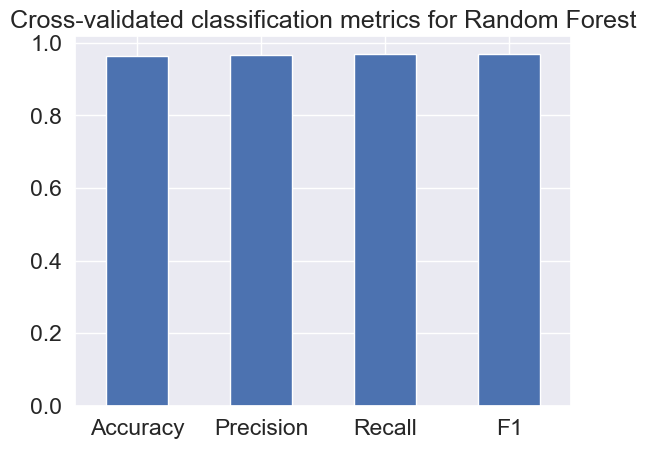

In [269]:
# Cross-validated accuracy
cv_acc_rf = cross_val_score(rs_rf_model, X, y, cv=5, scoring="accuracy")
cv_acc_rf = np.mean(cv_acc_rf)
# Cross-validated precision
cv_precision_rf = cross_val_score(rs_rf_model, X, y, cv=5, scoring="precision")
cv_precision_rf = np.mean(cv_precision_rf)
# Cross-validated recall
cv_recall_rf = cross_val_score(rs_rf_model, X, y, cv=5, scoring="recall")
cv_recall_rf = np.mean(cv_recall_rf)
# Cross-validated f1-score
cv_f1_rf = cross_val_score(rs_rf_model, X, y, cv=5, scoring="f1")
cv_f1_rf = np.mean(cv_f1_rf)
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc_rf,
                           "Precision": cv_precision_rf,
                           "Recall": cv_recall_rf,
                           "F1": cv_f1_rf},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics for Random Forest",
                       legend=False)
plt.xticks(rotation=0)
plt.show()

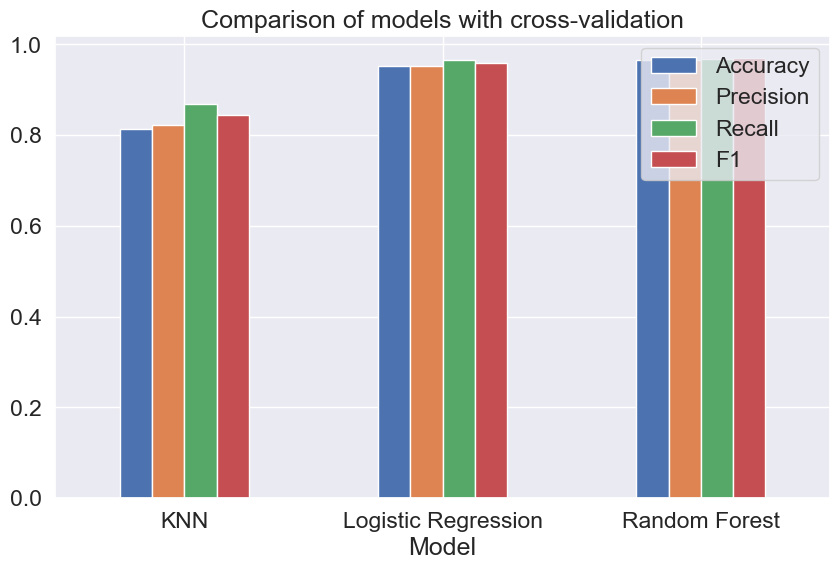

In [279]:
# Lưu kết quả của tất cả các mô hình vào DataFrame
cv_results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [cv_acc_knn, cv_acc_lr, cv_acc_rf],
    'Precision': [cv_precision_knn, cv_precision_lr, cv_precision_rf],
    'Recall': [cv_recall_knn, cv_recall_lr, cv_recall_rf],
    'F1': [cv_f1_knn, cv_f1_lr, cv_f1_rf]
})

# Vẽ biểu đồ so sánh các mô hình
cv_results.set_index('Model').plot.bar(title="Comparison of models with cross-validation", figsize=(10, 6))
plt.xticks(rotation=0)
plt.show()

### Evaluate Models with MAE, MSE, RMSE 

In [163]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Giả sử y_test là nhãn thật và y_preds là các dự đoán của mô hình
mae_knn_cv = np.round(mean_absolute_error(y_test, y_preds), 2)
mse_knn_cv = np.round(mean_squared_error(y_test, y_preds), 2)
rmse_knn_cv = np.round(np.sqrt(mean_squared_error(y_test, y_preds)), 2)

mae_lr_cv = np.round(mean_absolute_error(y_test, y_preds_rs_log_reg_model), 2)
mse_lr_cv = np.round(mean_squared_error(y_test, y_preds_rs_log_reg_model), 2)
rmse_lr_cv = np.round(np.sqrt(mean_squared_error(y_test, y_preds_rs_log_reg_model)), 2)

mae_rf_cv = np.round(mean_absolute_error(y_test, y_preds_rs_rf_model), 2)
mse_rf_cv = np.round(mean_squared_error(y_test, y_preds_rs_rf_model), 2)
rmse_rf_cv = np.round(np.sqrt(mean_squared_error(y_test, y_preds_rs_rf_model)), 2)

In [165]:
models = ['KNeighborsClassifier', 'LogisticRegression', 'RandomForestClassifier']
data = [[mae_knn_cv, mse_knn_cv, rmse_knn_cv], [mae_lr_cv, mse_lr_cv, rmse_lr_cv], [mae_rf_cv, mse_rf_cv, rmse_rf_cv]]
cols = ['mae', 'mse', 'rmse']
pd.DataFrame(data=data, index=models, columns = cols)

,mae,mse,rmse
KNeighborsClassifier,0.04,0.04,0.20
LogisticRegression,0.04,0.04,0.20
RandomForestClassifier,0.03,0.03,0.17


### Feature Importance

Feature Importance là cách để tìm xem feature nào đóng góp nhiều nhất cho output của mô hình<br>
Tìm Feature Importance cho mô hình LogisticRegression <br>

In [132]:
# Fit an instance of LogisticRegression

clf = LogisticRegression(C = 0.20433597178569418, 
                         solver = 'liblinear')
clf.fit(X_train,y_train);

In [134]:
# Check Coef_
clf.coef_

array([[-0.03886475,  0.55956008,  0.79485416,  0.72740193,  0.17232421,
         0.26819289,  0.56507758,  0.27581167,  0.02521551, -0.69003307,
         2.99517781,  0.34292056]])

In [136]:
# Match coef's of features to coloumns

feature_dict = dict(zip(df.columns,list(clf.coef_[0])))
feature_dict

{'patientid': -0.03886474621837453,
 'age': 0.5595600791196456,
 'gender': 0.7948541628682458,
 'chestpain': 0.7274019282414449,
 'restingBP': 0.1723242078262711,
 'serumcholestrol': 0.26819288950239223,
 'fastingbloodsugar': 0.5650775796078046,
 'restingrelectro': 0.275811670905447,
 'maxheartrate': 0.025215513741090885,
 'exerciseangia': -0.6900330685643917,
 'oldpeak': 2.995177809811862,
 'slope': 0.3429205617256397}

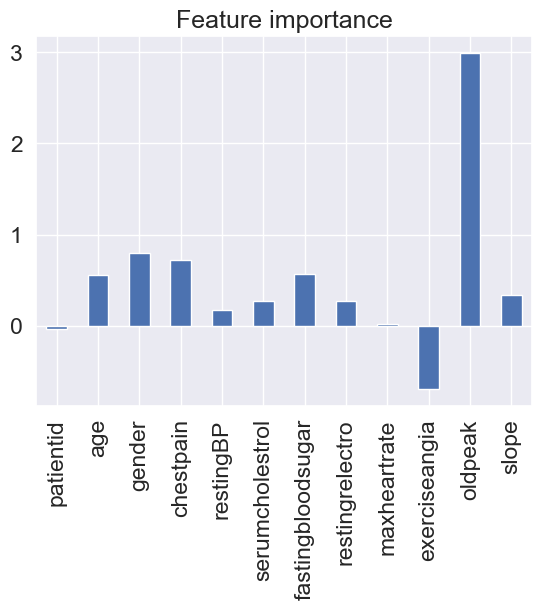

In [138]:
# Visualize Feature Importance
feature_df = pd.DataFrame(feature_dict,index=[0])
feature_df.T.plot.bar(title="Feature importance",legend=False);

In [ ]:
# Save the model
model_filename = 'model/model_ML.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(rs_rf_model, file)
print('Model Saved Succesfully!')

Model Saved Succesfully!
